In [15]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary
import torch_lr_finder

In [16]:
from model import ResNet
from trainer import Trainer
from tester import Tester
from dataloader import Cifar10DataLoader,Cifar10Dataset
from transformation import train_transforms, test_transforms
from utils import visualize_data,show_misclassified_images,plot_curves,plot_confusion_matrix,lr_curve

In [17]:
# CIFAR10 Data
train_data = Cifar10Dataset(root='../../data',train=True,download=False,transform=train_transforms)
test_data = Cifar10Dataset(root='../../data',train=False,download=False,transform=test_transforms)

# CIFAR10 DataLoader
loader = Cifar10DataLoader(batch_size=512,is_cuda_available=True)
train_loader = loader.get_loader(train_data,train=True)
test_loader  = loader.get_loader(test_data,train=False)

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Is CUDA available? ", use_cuda)


Is CUDA available?  True


In [19]:
model = ResNet(dropout_val=0.01,bias=False).to(device)
summary(model,(3,32,32),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
       BasicBlock-13          [-1, 128, 16, 16]               0
      CustomBlock-14          [-1, 128,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


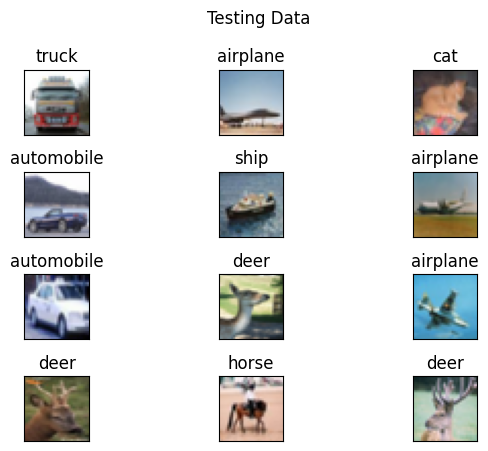

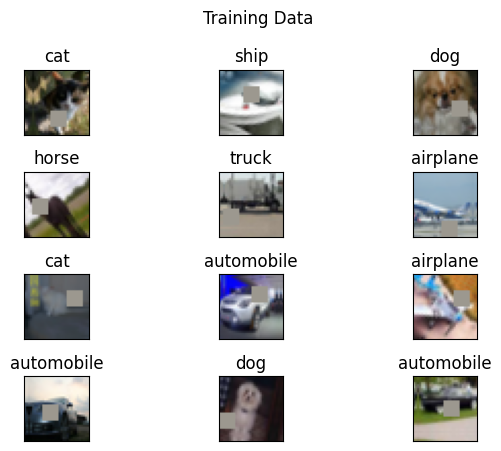

In [20]:

visualize_data(test_loader,12,"Testing Data",classes=test_data.classes);
visualize_data(train_loader,12,"Training Data",classes=train_data.classes);

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
EPOCH=24

 65%|██████▌   | 130/200 [00:32<00:17,  4.05it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.04E-02


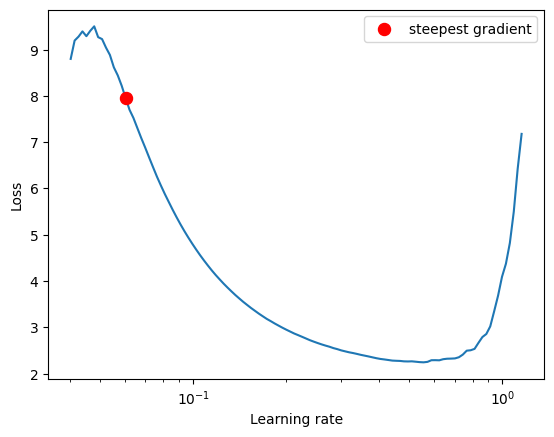

In [22]:
lr_finder = torch_lr_finder.LRFinder(model,optimizer,criterion,device=device)
lr_finder.range_test(train_loader,end_lr=10,num_iter=200,step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [23]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=6.04E-02, 
                                          pct_start=3/EPOCH,  #5/EPOCH
                                          anneal_strategy='linear',
                                        #   cycle_momentum=True,
                                        #   base_momentum=0.85,
                                        #   max_momentum=0.98,
                                          steps_per_epoch=len(train_loader),
                                          epochs= EPOCH,
                                          three_phase=False,
                                          div_factor=100,
                                          final_div_factor=100
            )



trainer = Trainer(model, train_loader, optimizer, criterion,scheduler, device)
tester = Tester(model, test_loader, criterion, device)


target_acc = 90
for epoch in range(0, EPOCH):
    trainer.train(epoch=epoch)
    test_acc,test_loss = tester.test()
    if test_acc>target_acc:
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'scheduler':scheduler.state_dict(),
            'epoch':epoch
        },f"./assets/best_model_{test_acc}.pth")
        target_acc = test_acc

    print('-'*150)

EPOCH=0| LR=0.020604027303754265| LOSS=1.94| BATCH=97| ACCURACY=35.364: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s] 
LOSS=60.33| BATCH=19| ACCURACY=30.040: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=1| LR=0.04060405460750853| LOSS=1.52| BATCH=97| ACCURACY=43.274: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s] 
LOSS=27.61| BATCH=19| ACCURACY=51.390: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=2| LR=0.060370654052478136| LOSS=1.28| BATCH=97| ACCURACY=53.636: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
LOSS=22.55| BATCH=19| ACCURACY=59.880: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=3| LR=0.05749475119533528| LOSS=1.15| BATCH=97| ACCURACY=60.760: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=20.50| BATCH=19| ACCURACY=65.300: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=4| LR=0.05461884833819242| LOSS=1.07| BATCH=97| ACCURACY=63.392: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s] 
LOSS=20.72| BATCH=19| ACCURACY=64.810: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=5| LR=0.05174294548104956| LOSS=1.02| BATCH=97| ACCURACY=64.774: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s] 
LOSS=26.71| BATCH=19| ACCURACY=57.810: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=6| LR=0.048867042623906704| LOSS=0.97| BATCH=97| ACCURACY=66.146: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
LOSS=20.65| BATCH=19| ACCURACY=66.480: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=7| LR=0.04599113976676385| LOSS=0.99| BATCH=97| ACCURACY=66.530: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=21.47| BATCH=19| ACCURACY=64.950: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=8| LR=0.04311523690962099| LOSS=0.92| BATCH=97| ACCURACY=67.420: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s] 
LOSS=19.82| BATCH=19| ACCURACY=65.140: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=9| LR=0.040239334052478135| LOSS=0.88| BATCH=97| ACCURACY=68.108: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
LOSS=15.80| BATCH=19| ACCURACY=72.550: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=10| LR=0.03736343119533528| LOSS=0.97| BATCH=97| ACCURACY=68.564: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=20.37| BATCH=19| ACCURACY=66.170: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=11| LR=0.03448752833819242| LOSS=0.95| BATCH=97| ACCURACY=69.510: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=19.90| BATCH=19| ACCURACY=65.990: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=12| LR=0.031611625481049566| LOSS=0.88| BATCH=97| ACCURACY=69.888: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
LOSS=15.15| BATCH=19| ACCURACY=74.320: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=13| LR=0.028735722623906702| LOSS=0.76| BATCH=97| ACCURACY=70.700: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
LOSS=16.56| BATCH=19| ACCURACY=72.670: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=14| LR=0.025859819766763853| LOSS=0.83| BATCH=97| ACCURACY=71.508: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
LOSS=14.26| BATCH=19| ACCURACY=75.070: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=15| LR=0.02298391690962099| LOSS=0.86| BATCH=97| ACCURACY=72.504: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=14.71| BATCH=19| ACCURACY=74.930: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=16| LR=0.020108014052478133| LOSS=0.76| BATCH=97| ACCURACY=72.846: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
LOSS=11.70| BATCH=19| ACCURACY=79.830: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=17| LR=0.017232111195335277| LOSS=0.72| BATCH=97| ACCURACY=74.348: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
LOSS=14.12| BATCH=19| ACCURACY=76.000: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=18| LR=0.01435620833819242| LOSS=0.67| BATCH=97| ACCURACY=75.256: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s] 
LOSS=11.37| BATCH=19| ACCURACY=80.100: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=19| LR=0.011480305481049558| LOSS=0.65| BATCH=97| ACCURACY=76.854: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
LOSS=10.28| BATCH=19| ACCURACY=82.680: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=20| LR=0.008604402623906708| LOSS=0.61| BATCH=97| ACCURACY=77.774: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
LOSS=10.92| BATCH=19| ACCURACY=81.620: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=21| LR=0.005728499766763845| LOSS=0.61| BATCH=97| ACCURACY=79.462: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s] 
LOSS=8.51| BATCH=19| ACCURACY=85.260: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=22| LR=0.0028525969096209955| LOSS=0.49| BATCH=97| ACCURACY=81.848: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
LOSS=7.54| BATCH=19| ACCURACY=86.950: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------


EPOCH=23| LR=-2.3305947521867765e-05| LOSS=0.51| BATCH=97| ACCURACY=83.782: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
LOSS=6.78| BATCH=19| ACCURACY=88.410: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------


In [24]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

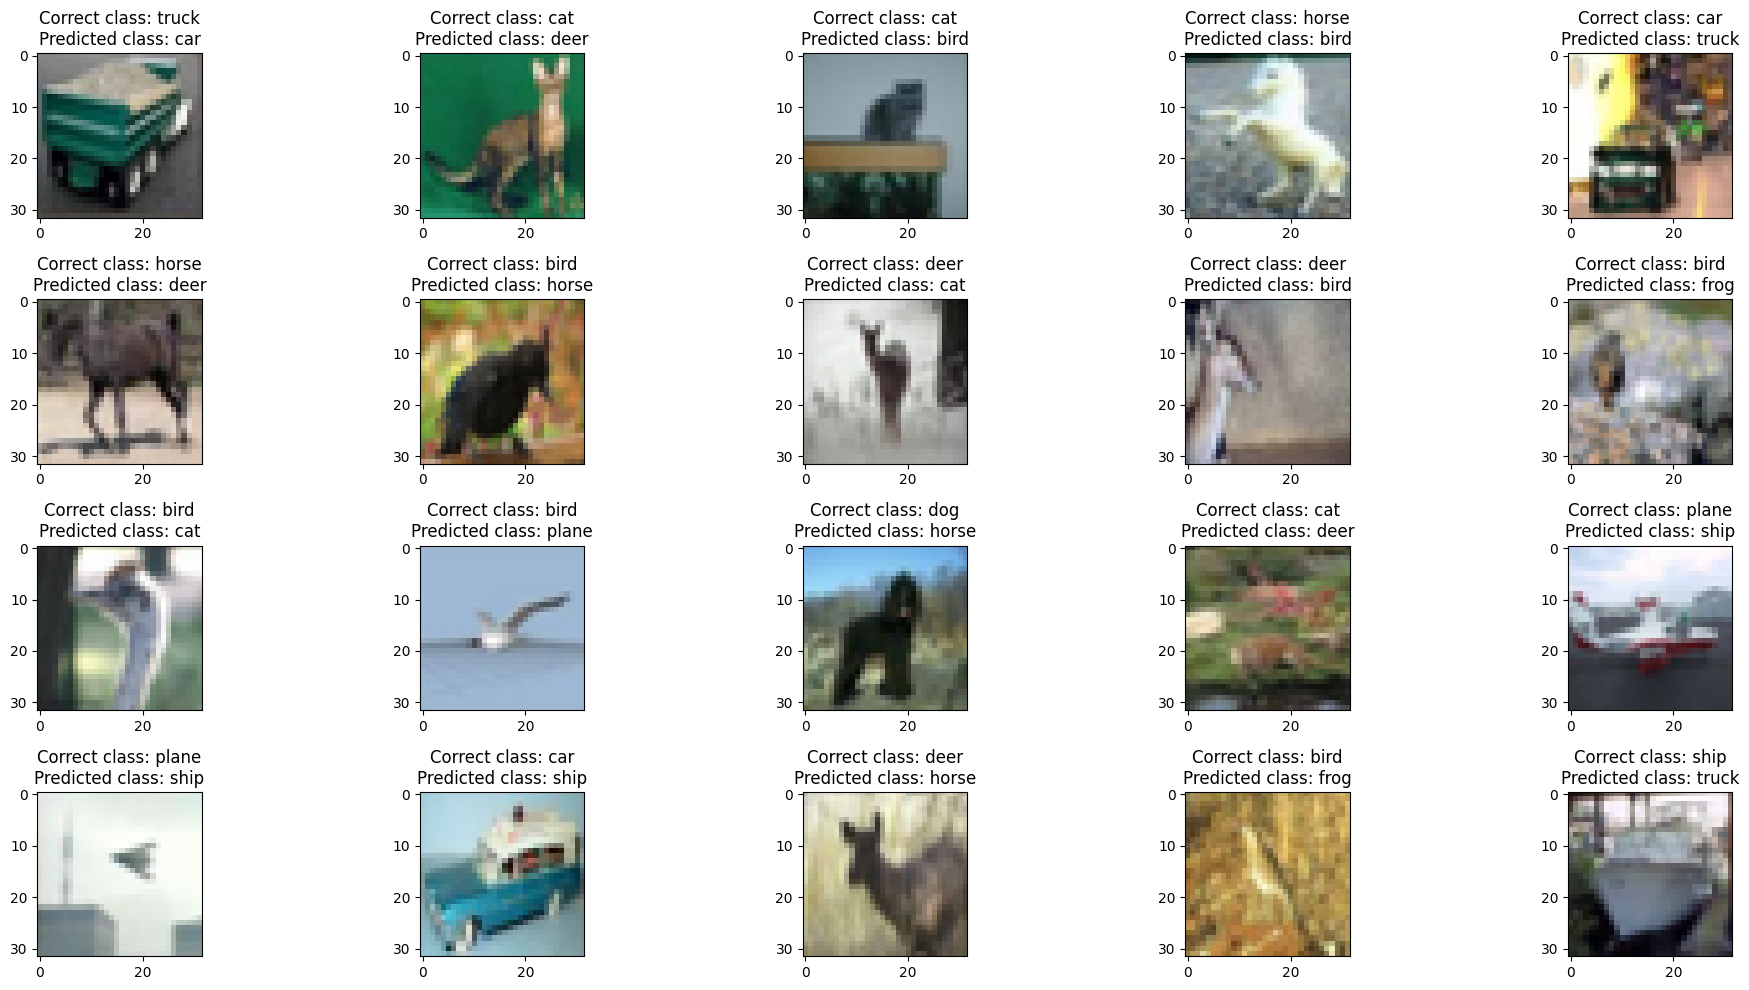

In [25]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ],
);


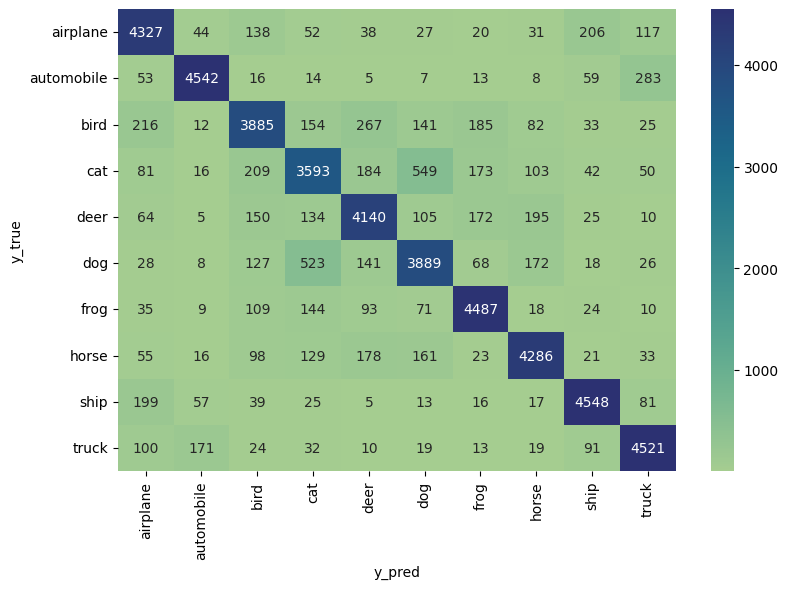

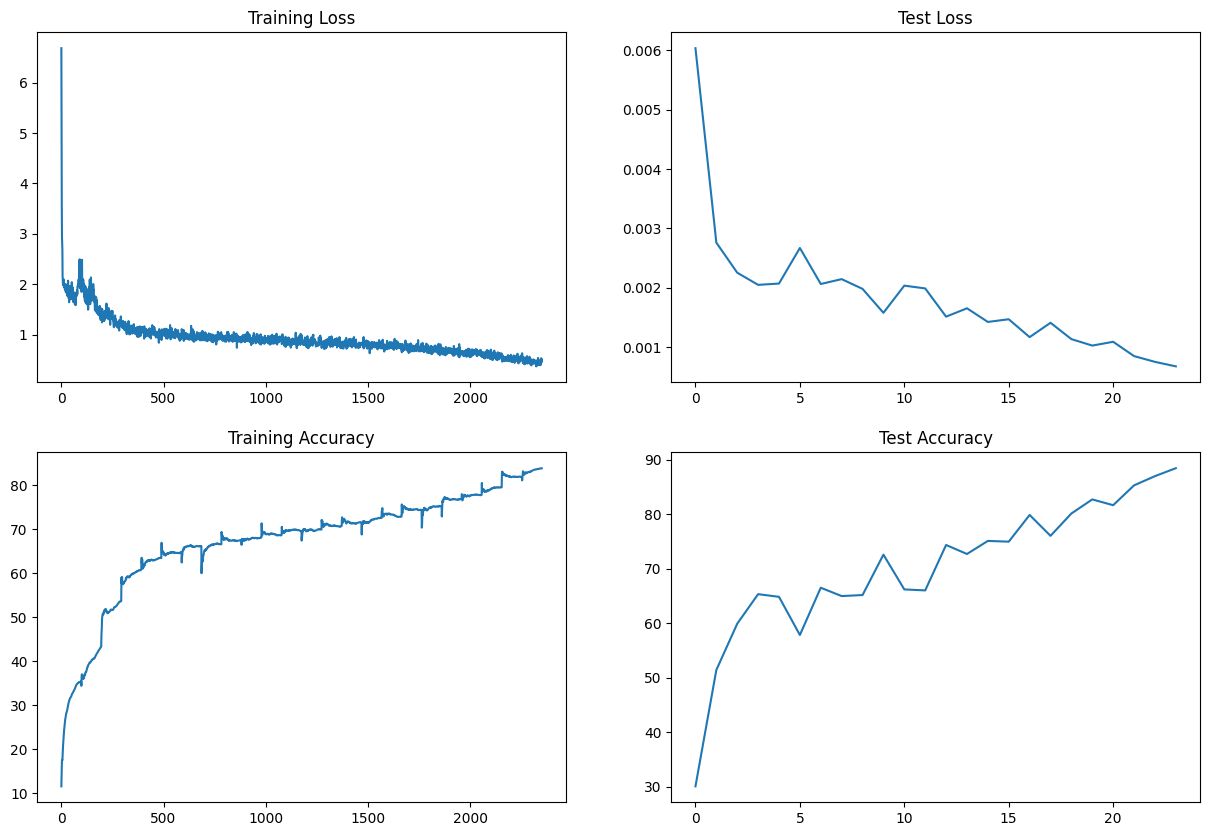

In [26]:
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes);
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies);

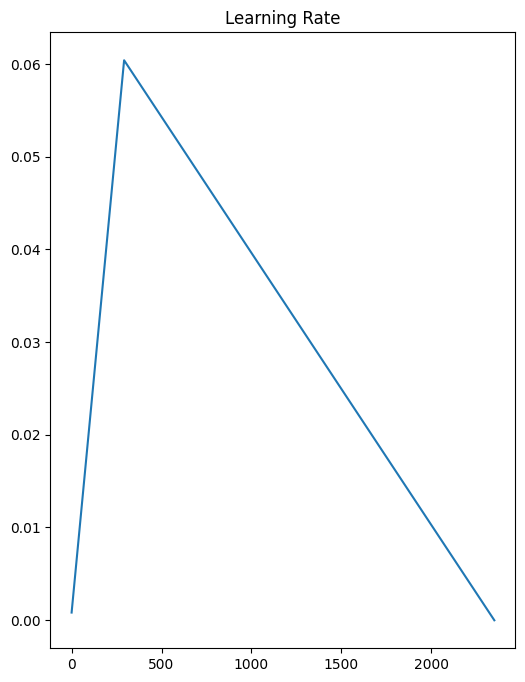

In [27]:
lr_curve(trainer.lr_history)